<a href="https://colab.research.google.com/github/smih/BU_workshop_data/blob/main/BU_workshop_code_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantifying comparisons between sets of neural activity**

by Kathleen Esfahany$^{1, 2}$ and Stefan Mihalas$^{1}$

*$^{1}$ Allen Institute, $^{2}$ Harvard Program in Neuroscience*


**Table of Contents**

>[Quantifying comparisons between sets of neural activity](#scrollTo=av3D9V9X0N7A)

>[[1] Motivation](#scrollTo=AR-mi4Bd3Pje)

>>[[1.1] Instructions](#scrollTo=LqKJahqrVy5q)

>>[[1.2] Questions](#scrollTo=SmsgNJf_YpSw)

>[[2] Measuring dimensionality](#scrollTo=6QEA9z5lGh_z)

>>[[2.1] Definitions](#scrollTo=-yehUzY2Rseo)

>>>[Covariance](#scrollTo=Ya7ivKWeaYWL)

>>>[Principal Component Analysis (PCA)](#scrollTo=M6RTqAh72-wl)

>>>[Participation Ratio](#scrollTo=AG8VAxoq3ANj)

>>[[2.2] Demonstrations](#scrollTo=NGLb_k7IRwnv)

>>>[[2.2.1] Calculating participation ratio](#scrollTo=Kg5o0P8dH1PW)

>>>[[2.2.2] Running PCA](#scrollTo=qtOAdQd_LKny)

>[[3] Angle between subspaces](#scrollTo=vEeKiNyYR-rO)

>>[[3.1] Angle between flats](#scrollTo=TwjPvHxxeoe4)

>>>[[3.1.1] Hadamard matrix example](#scrollTo=dtYFzkrFrRaG)

>>>[[3.1.2] Toy dataset example #1: comparing two datasets](#scrollTo=CEbe9jf5oifD)

>>>[[3.1.3] Toy dataset example #2: comparing a set of smoothly changing datasets with angle between flats](#scrollTo=heUEaskeSLfJ)

>>[[3.2] q alignment](#scrollTo=Y-MoSP3CTjal)

>>>[[3.2.1] Calculating $q$](#scrollTo=eieCkH0yZmeV)

>>>[[3.2.2] Calculating $q_{\text{multi}}$](#scrollTo=AYzL82CyqTMZ)

>>>[[3.2.3] Toy dataset example: comparing a set of smoothly changing datasets with q_multi](#scrollTo=c7RYdC7HD-o2)

>[[4] Allen Institute Visual Coding Neuropixels Dataset](#scrollTo=fl_kyOJc3gZz)

>>[[4.1] Loading neural data](#scrollTo=QEGFjNKCQuNr)

>>>[[4.1.1] Understanding the data format](#scrollTo=SWLcb6SWTame)

>>[[4.2] Plotting the neural data](#scrollTo=-4Dw6o16mEKm)

>>>[[4.2.1] Activity for one repeat of the movie](#scrollTo=j4MrOqGInIfq)

>>>[[4.2.2] Activity for a given one-second bin of the movie, across all repeats](#scrollTo=CO8-QfjmnMs9)

>>>[[4.2.3] Visualizing difference in activity between sessions](#scrollTo=UQKcOmYenT7J)

>>[[4.3] Geometric analyses (Aitken et al., 2022)](#scrollTo=mmgL0xGvtZUE)

>>>[[4.3.1] Defining terms](#scrollTo=l391eU0V6NKy)

>>>[[4.3.2] Visualizing and calculating drift vector](#scrollTo=8ZnXTvjkAsOb)

>>>>[i. Example drift vector (visualization)](#scrollTo=i896bQeGAwsZ)

>>>>[ii. Calculating drift vector for all 30 stimulus bins](#scrollTo=Mo2CDwd5KEyK)

>>>>[iii. Visualizing all drift vectors for all 30 stimulus bins](#scrollTo=xWv8_SKrHNRC)

>>>[[4.3.3] Measuring alignment of drift vector with the neural activity](#scrollTo=xSZwj_8wMmJq)

>>>>[i. Magnitude of $d$ along PCs](#scrollTo=RFdDo0nZbJNJ)

>>>>[ii. Angle of $d$ with PCs](#scrollTo=Bo0oJfaNbNYE)



In [ ]:
# @title Import packages
import random
import pandas as pd
from IPython.display import display # for displaying Pandas output more nicely
import numpy as np
from numpy import linalg as la
from sklearn.decomposition import PCA
import statsmodels.api as sm
import scipy as sp
from scipy.linalg import hadamard, subspace_angles
import matplotlib.pyplot as plt
import plotly.express as px

# Links to datasets used in this notebook
data_source_links = {
    "synthetic_data": "https://github.com/esfahany/workshop-data/raw/main/synthetic_data.pkl",
    "synthetic_data_centered": "https://github.com/esfahany/workshop-data/raw/main/synthetic_data_centered.pkl"
}

# Colors used in this notebook
color_list = ["#d81159", "#FF8020", "#0496ff", "#0077CC", "#005FA3", "#00477A"]

# **[1] Motivation**

**Key question:** How can we quantitatively compare two sets of neural activity?

In this notebook, we explore **geometric** ways of comparing neural activity.


## **[1.1] Instructions**
* We have generated six synthetic "toy" datasets to use in this workshop.
    * *If you'd like to see how we generated these datasets, you can view the Colab Notebook [here](https://colab.research.google.com/drive/1MuRuPc9h9_wgZTA3XwMMPPguCFwJrJp4?usp=sharing)*.
* Each dataset contains activity from three neurons.
* Run the code blocks below to load and plot the toy datasets.
    * Please note that we have two versions of the toy datasets, `toy_df` where the datasets are spread out along the x-axis (mainly for ease of visual inspection) and `toy_df_centered` where they are centered at the origin (to help with plotting and comparing between datasets).
* The figure plots **three** of the six toy datasets. In the plot, each axis corresponds to the activity of one neuron.
* Explore the interactive figure the code produces. Use your mouse to rotate and zoom on the figure.




## **[1.2] Questions**
* What do you observe? How are these three sets of activity similar and how are they different?
* How could you quantify the degree of similarity (or difference) between these sets of activity?

In [ ]:
# Load toy data (contains three different datasets of activity, indicated by "dataset_id" value 0, 1, or 2)
toy_df = pd.read_pickle(data_source_links["synthetic_data"]) # columns = neurons (x, y, z), rows = samples of activity
toy_df_centered = pd.read_pickle(data_source_links["synthetic_data_centered"]) # columns = neurons (x, y, z), rows = samples of activity

In [ ]:
# Preview a few rows of the full DataFrame
print("Full toy DataFrame:")
display(toy_df.head(5))

# Create a list of separate DataFrames for each individual dataset
toy_datasets = [toy_df.loc[toy_df["dataset_id"] == f"{i}"][["x", "y", "z"]] for i in toy_df["dataset_id"].unique()]
toy_datasets_centered = [toy_df_centered.loc[toy_df["dataset_id"] == f"{i}"][["x", "y", "z"]] for i in toy_df_centered["dataset_id"].unique()]

# Preview a few rows of an individual dataset's DataFrame
print("\nDataFrame for one of the three individual datasets of activity:")
display(toy_datasets[0].head(5))

# Preview a few rows of the centered version of the same individual dataset's DataFrame
print("\nDataFrame for one of the t individual dataset of activity:")
display(toy_datasets_centered[0].head(5))

Full toy DataFrame:


,x,y,z,dataset_id
0,8.117883,9.759367,9.038485,0
1,8.671609,9.986250,8.863985,0
2,8.742665,11.554376,8.012876,0
3,8.082837,9.165026,10.187344,0
4,10.517215,10.401891,10.706330,0



DataFrame for one of the three individual datasets of activity:


,x,y,z
0,8.117883,9.759367,9.038485
1,8.671609,9.986250,8.863985
2,8.742665,11.554376,8.012876
3,8.082837,9.165026,10.187344
4,10.517215,10.401891,10.706330



DataFrame for one of the t individual dataset of activity:


,x,y,z
0,-0.293665,0.634273,0.451659
1,1.641362,0.489466,-1.079498
2,0.747636,0.016823,0.540929
3,0.600936,0.173061,-0.380388
4,0.068086,-1.911967,1.651448


In [ ]:
# Plot the first three toy datasets
fig = px.scatter_3d(toy_df[toy_df["dataset_id"].isin(["0", "1", "2"])], x="x", y="y", z="z", color='dataset_id', color_discrete_sequence = color_list, labels = {"x": "Neuron 1","y": "Neuron 2", "z": "Neuron 3"}, title = "Toy examples of neural activity")
fig.update_traces(marker_size=3) # reduce size of scatter points from default size
fig.update_layout(width=800, height=600, font_size=11, scene_aspectmode="data", scene_camera_eye= dict(x=0.2, y=-2.0, z=1)) # adjust plot appearance
fig.show()

#[2] **Measuring dimensionality**

Below, we introduce concepts needed to understand the **participation ratio**, a useful measure of the effective dimension of neural activity.

## [2.1] Definitions

### **Covariance**
* **Covariance** is a measure of the joint variability of two variables.
* Covariance is positive when the variables tend to move in the same direction, and negative when they tend to move in opposite directons.
* For two variables $X$ and $Y$, one way to calculate the covariance is:

$$ \mathrm{cov}_{x, y} = \frac{\sum_{i = 1}^N (X_i - \bar{X})(Y_i -
\bar{Y})}{N} $$

### **Principal Component Analysis (PCA)**

* **Principal Component Analysis** (**PCA**) is a widely used analysis of population dynamics in which activity is decomposed along orthogonal patterns called principal components (PCs).
* How does PCA relate to covariance? PCs are the **eigenvectors** of the covariance matrix $C$. The associated **eigenvalues** $\lambda_i$ are nonnegative and are the amount of variance distributed along the PCs.

### **Participation Ratio**

The **participation ratio** is a useful measure of the effective dimension of neural activity. In other words, the participation ratio roughly quantifies how many PCs are needed to capture the majority of the variance in the population. We define the participation ratio, $D$, as:

$$D \equiv \frac{(\sum_{i=1}^N \lambda_i)^2}{\sum_{i=1}^N\lambda_i^2}$$

------

***References & further reading***:
* [Eigenvalue Spectra of Random Matrices for Neural Networks](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.97.188104) by Rajan and Abbott (2006) [[PDF]](http://www.columbia.edu/cu/neurotheory/Larry/RajanPRL06.pdf)
* [A theory of multineuronal dimensionality, dynamics and measurement](https://www.biorxiv.org/content/10.1101/214262v2) by Gao et al. (2017)
* [The spectrum of covariance matrices of randomly connected recurrent neuronal networks with linear dynamics](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1010327) by Hu and Sompolinsky (2022)

## [2.2] Demonstrations

The code block below contains functions for calculating covariance, eigenvalues, and the participation ratio.

In [ ]:
def covariance(neural_activity):
    """
    Args:
        neural_activity (DataFrame): n neurons as columns and activity samples as rows
    Returns:
        covariance_matrix (DataFrame): n x n
    """
    covariance_matrix = neural_activity.cov(numeric_only=True) # use Pandas ".cov" to get covariance from neural_activity DataFrame
    return covariance_matrix

def eigenvalues(covariance_matrix):
    """
    Args:
        covariance_matrix (DataFrame): n x n
    Returns:
        eigenvalues (1D-array)
    """
    eigenvalues, eigenvectors = la.eig(covariance_matrix) # use numpy to get eigenvalues and eigenvectors from covariance matrix
    return eigenvalues

def participation_ratio(neural_activity):
    """
    Args:
        neural_activity (DataFrame): n neurons as columns and activity samples as rows
    """
    C = covariance(neural_activity) # calculate covariance
    lambda_array = eigenvalues(C) # get the eigenvalues of the covariance matrix
    D = (np.sum(lambda_array)**2) / np.sum(lambda_array**2) # calculate participation ratio from eigenvalues
    return D


### [2.2.1] Calculating participation ratio

- Run the code block below to print the **participation ratio** for each of the three toy datasets.

- Do these results align with what you can observe visually about these datasets?

In [ ]:
print("Dataset", "Participation Ratio", sep="\t")
for i in range(3):
    print(i, np.round(participation_ratio(toy_datasets[i]), 3), sep= "\t")

Dataset	Participation Ratio
0	2.988
1	2.105
2	1.258


### [2.2.2] Running PCA

Let's also use scikit-learn to run PCA on these datasets.

Below are some of the relevant attributes:
* `components_`: The principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by decreasing explained variance.
* `explained_variance_`: The amount of variance in the original data epxlained by each of the principal components.
* `explained_variance_ratio_`: The **percentage** of variance explained by each of the selected components.

**Instructions**:
* Run the code blocks below.
* Observe the proportion of variance explained by each PC across the different datasets (gray bar plots).
* Do these results align with what you can observe visually about the datasets, and with the participation ratios we calculated earlier?

In [ ]:
# Run PCA
pca_results_dict = {}
for dataset_num in range(6): # for each dataset
    pca = PCA() # create PCA model
    transformed_data = pca.fit_transform(toy_datasets[dataset_num]) # fit the model with the dataset
    components = pca.components_ # list of principal components (PCs)
    explained_variance_ratio = pca.explained_variance_ratio_ # list of proportion of explained variance for each PC
    pca_results_dict[dataset_num] = {"components": components, "explained_variance_ratio": explained_variance_ratio} # add results to dictionary
pca_results = pd.DataFrame(pca_results_dict).T # make a DataFrame
pca_results.head(3) # view PCA results for the first three toy datasets

,components,explained_variance_ratio
0,"[[0.26096132376497594, 0.1933182671041298, 0.9...","[0.3538468082021429, 0.34234056774252, 0.30381..."
1,"[[-0.1047048975904533, 0.016147089974906437, 0...","[0.5366944650811866, 0.43139826533267306, 0.03..."
2,"[[0.006857028313453552, 0.9998982519953965, -0...","[0.8880149502501843, 0.060457609933152384, 0.0..."


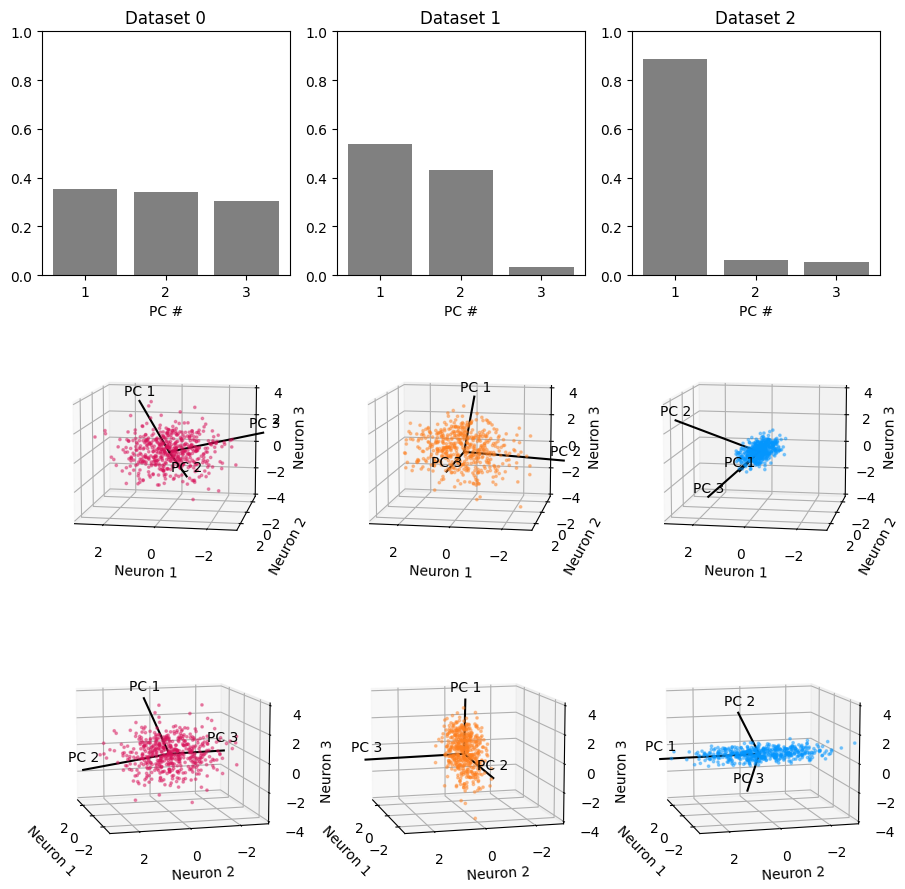

In [ ]:
#@title Plot PCA results

# set up figure and define subplot format (# rows and cols)
fig = plt.figure(figsize = (9, 9))
ROWS = 3
COLS = 3

for dataset_num in range(3): # for each of the first three datasets

    components, explained_variance_ratio = pca_results.iloc[dataset_num][["components", "explained_variance_ratio"]]
    centered_df = toy_datasets_centered[dataset_num] # get centered data for plotting
    # centered_df = center_toy_df(toy_datasets[dataset_num], dataset_num) # get centered data for plotting

    ##### ROW 1
    # 1) bar plot PCs by proportion of explained variance
    subplot = fig.add_subplot(ROWS, COLS, dataset_num+1)
    subplot.bar(np.arange(1, 4), explained_variance_ratio, color = "gray")
    subplot.set_xticks([1, 2, 3])
    subplot.set_xlabel("PC #")
    subplot.set_ylim(0, 1)
    if i == 0:
        subplot.set_ylabel("Proportion Variance Explained")
    subplot.set_title(f"Dataset {dataset_num}")

    ##### ROW 2 (data + PCs, view 1)
    # 2a) scatter plot data
    subplot = fig.add_subplot(ROWS, COLS, dataset_num+4, projection="3d")
    subplot.scatter(centered_df["x"],centered_df["y"],centered_df["z"], color = color_list[dataset_num], s = 3, alpha = 0.4)
    subplot.set_xlim(-3, 3); subplot.set_ylim(-3, 3); subplot.set_zlim(-4, 4)
    subplot.set_xlabel("Neuron 1"); subplot.set_ylabel("Neuron 2"); subplot.set_zlabel("Neuron 3")

    # 2b) draw PCs
    for c_idx in range(3):
        c = components[c_idx]*4
        pca_plot = np.column_stack((np.zeros(3), c))
        subplot.plot(pca_plot[0], pca_plot[1], pca_plot[2], color="k")
        subplot.text(c[0]+0.5, c[1]+0.5, c[2]+0.5, f"PC {c_idx+1}")
    subplot.view_init(elev=10, azim=100, roll=0)

    ##### ROW 3 (data + PCs, view 2)
    # 3a) scatter plot data
    subplot = fig.add_subplot(ROWS, COLS, dataset_num+7, projection="3d")
    subplot.scatter(centered_df["x"],centered_df["y"],centered_df["z"], color = color_list[dataset_num], s = 3, alpha = 0.4)
    subplot.set_xlim(-3, 3); subplot.set_ylim(-3, 3); subplot.set_zlim(-4, 4)
    subplot.set_xlabel("Neuron 1"); subplot.set_ylabel("Neuron 2"); subplot.set_zlabel("Neuron 3")

    # 3b) draw PCs
    for c_idx in range(3):
        c = components[c_idx]*4
        pca_plot = np.column_stack((np.zeros(3), c))
        subplot.plot(pca_plot[0], pca_plot[1], pca_plot[2], color="k")
        subplot.text(c[0]+0.5, c[1]+0.5, c[2]+0.5, f"PC {c_idx+1}")
    subplot.view_init(elev=10, azim=165, roll=0)

plt.tight_layout()
plt.show()

# [3] Angle between subspaces



## [3.1] Angle between flats

* One measure to quantify the misalignment between subspaces is the "angle between flats" measure ([Wikipedia](https://en.wikipedia.org/wiki/Angles_between_flats)).
* This measure can be calculated via the scipy function ```scipy.linalg.subspace_angles(A, B)``` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.subspace_angles.html)), which returns the subspace angles between the column spaces of $A$ and $B$ in descending order.
* Some **[basic properties](https://en.wikipedia.org/wiki/Angles_between_flats#Basic_properties)** of the angle between flats include:
    * If the largest angle is zero, one subspace is a subset of the other.
    * If the largest angle is $\pi/2$ radians (90 deg),  there is at least one vector in one subspace perpendicular to the other subspace.
    * If the smallest angle is zero, then the subspaces intersect in at least a line.
    * If the smallest angle is $\pi/2$ radians (90 deg), then the subspaces are orthogonal.
    * The number of angles equal to zero is the dimension of the space where the two subspaces intersect.


In [ ]:
def angle_between_subspaces(A, B, round=3):
    """
    A and B are arrays with the same number of rows

    round is an optional arguement with default value = 3

    Returns the angle between flats *in degrees*
    """
    angles = subspace_angles(A, B) # calculate angle between flats using scipy
    angles_deg = np.rad2deg(angles) # convert from rad to deg
    angles_deg_rounded = np.round(angles_deg, round) # round to 3rd decimal (to avoid long trails of decimals)
    return angles_deg_rounded

### [3.1.1] Hadamard matrix example
Let's explore the concept of "angles between flats" with a **Hadamard matrix**, which is defined as a square matrix whose entries are either $1$ or $-1$ and whos rows are mutually orthogonal. This means that each pair of rows in a Hadamard matrix represents two perpendicular vectors. These properties hold for columns as well.

In [ ]:
##### First, let's create a Hadamard matrix called H

n_rows = 4 # must be a power of 2
H = hadamard(n_rows) # create Hadamard matrix (H)
print(H) # print H

[[ 1  1  1  1]
 [ 1 -1  1 -1]
 [ 1  1 -1 -1]
 [ 1 -1 -1  1]]


In [ ]:
##### Just for educational purposes, here we demonstrate a key property of H (all pairs of rows in H are perpendicular)

for i in range(n_rows):
    for j in range(i+1, n_rows):
        assert (np.dot(H[i], H[j]) == 0) # dot product of orthogonal vectors = 0

In [ ]:
##### Next, let's use the orthogonal columns of H to define two subspaces

subspace_1 = H[:, :3] # Columns 1, 2, 3 of H
subspace_2 = H[:, 1:] # Columns 2, 3, 4 of H

print("subspace 1", subspace_1, sep="\n")
print("\nsubspace 2", subspace_2, sep="\n")

subspace 1
[[ 1  1  1]
 [ 1 -1  1]
 [ 1  1 -1]
 [ 1 -1 -1]]

subspace 2
[[ 1  1  1]
 [-1  1 -1]
 [ 1 -1 -1]
 [-1 -1  1]]


Above, we've defined two subspaces (```subspace_1``` and ```subspace_2```) using the columns of $H$.
* The first column vector of ```subspace_1``` is orthogonal to the entirety of ```subspace_2```.
* The other two column vectors of ```subspace_1``` intersect with ```subspace_2```.

Run the code block below to calculate the angle between these subspaces. **Does the output match your understanding of the properties of "angles between flats" we covered above, and the properties of the subspaces we define?** Try changing the columns that compose ```subspace_1``` and ```subspace_2``` and observe the corresponding changes to the angle between subspaces.

In [ ]:
##### Finally, we calculate angle between flats (in degrees)
angle_between_subspaces(subspace_1, subspace_2)

array([90.,  0.,  0.])

### [3.1.2] Toy dataset example #1: comparing two datasets
Let's come back to the toy datasets.

**Instructions**:
* Run the code block below to run PCA again and plot the PC vectors of the datasets.

    * ***Important Note***: You can click on the labels in the plot legend to show/hide the lines corresponding to each label.

* Visually examine the **top PCs** for Datasets "1" (**<font color="#FF8020">orange</font>**) and "2" (**<font color="#0496ff">blue</font>**) (*note that the first dataset, plotted in pink, is Dataset "0"*).

    * For this exercise, let's define the top PCs as those that explain ≥10% of the variance in the data. As such, the top PCs for Dataset 1 are PCs 1 and 2, and for Dataset 2 is PC 1.

* **What angle do you see between the top PCs?**

In [ ]:
# @title Run PCA and plot PC vectors
color_list_expanded = np.concatenate([[color_list[i]]*3 for i in range(3)]) # hack for plot

pca_plot_dict = {"x":[], "y":[],"z":[], "label":[]} # empty dict to be filled in loop below

for dataset_num in range(3): # for each dataset

    # Retrieve PCA results (calculated earlier)
    components, explained_variance_ratio = pca_results.iloc[dataset_num][["components", "explained_variance_ratio"]]

    # Prepare for plotting the PCs
    for pc_num in range(3):
        # select the PC and add vector to dict
        c = components[pc_num]
        pca_plot_dict["x"].extend([0, c[0]])
        pca_plot_dict["y"].extend([0, c[1]])
        pca_plot_dict["z"].extend([0, c[2]])

        # create a label (for plotting purposes) and add to dict
        label = f"Dataset {dataset_num}, PC {pc_num}, {np.round(explained_variance_ratio[pc_num]*100, 0)}% var. exp." # label for legend
        pca_plot_dict["label"].extend([label, label])

# Plot PCs
pca_df = pd.DataFrame(pca_plot_dict)
fig = px.line_3d(pca_df, x="x", y="y", z="z", color='label', color_discrete_sequence = color_list_expanded, range_x = [-1, 1], range_y = [-1, 1], range_z = [-1, 1])
fig.show()

Below is a screenshot of the plot above with only Dataset "1" PCs 1 and 2 and Dataset "2" PC 1 shown. Observe that the top PCs of Datasets "1" and "2" are approximately orthogonal.

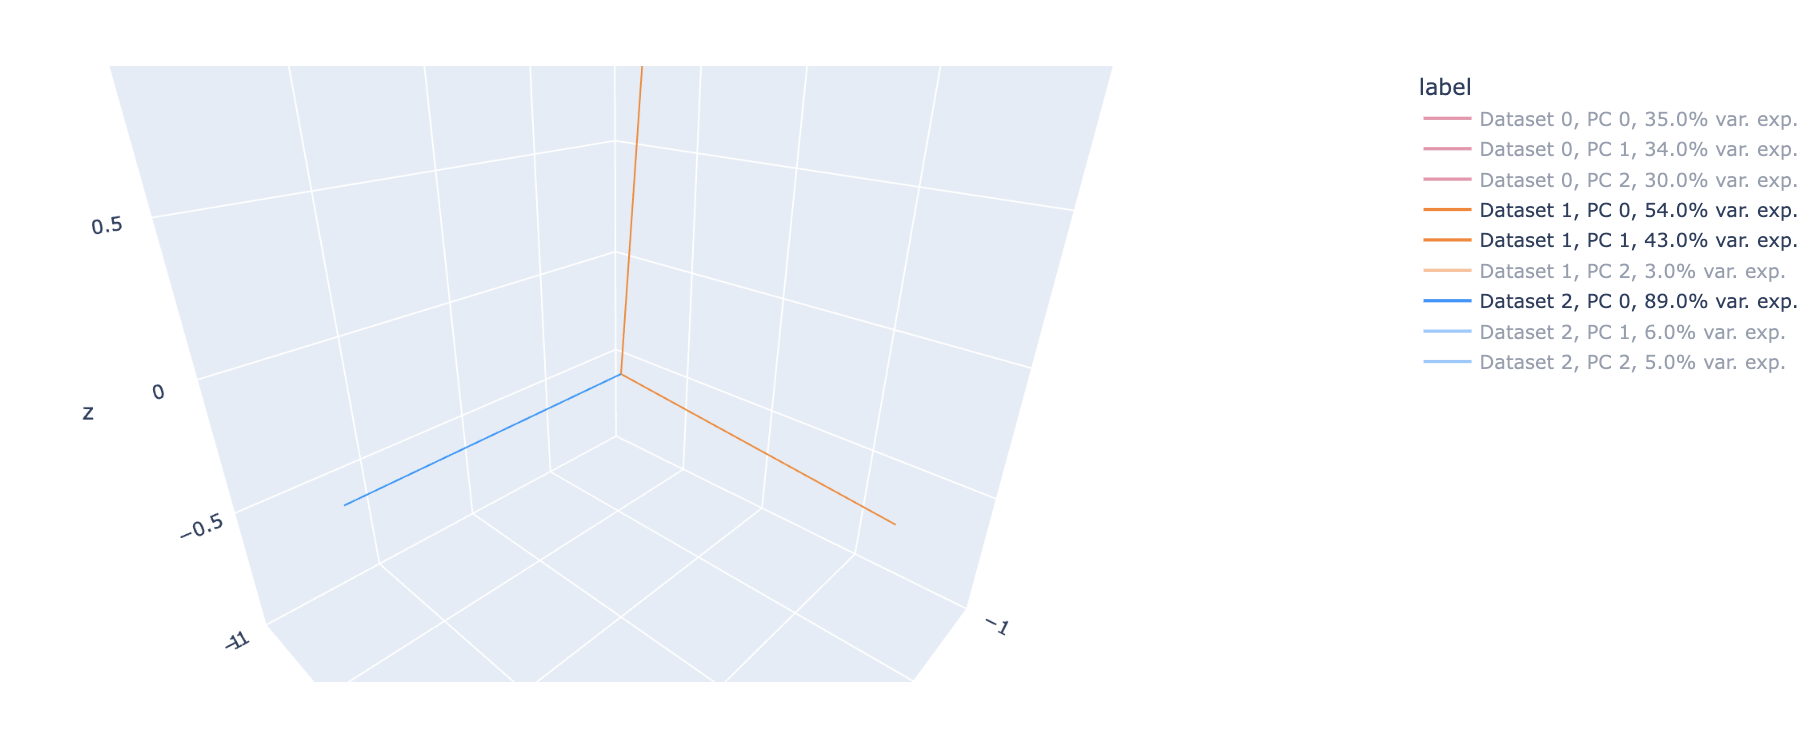

**Exercise**: For Datasets "1" (**<font color="#FF8020">orange</font>**) and "2" (**<font color="#0496ff">blue</font>**), find the angle between the subspaces generated by the top PCs (the components which explain more than 10% of the variance).

In [ ]:
def get_top_pcs(dataset_num, threshold_exp_var_ratio=0.10):
    components, explained_variance_ratio = pca_results.iloc[dataset_num][["components", "explained_variance_ratio"]]
    top_pcs = np.array([components[i] for i in range(len(components)) if explained_variance_ratio[i] >= threshold_exp_var_ratio])
    return top_pcs

In [ ]:
# get top PCs for datsets 1 and 2; transpose (.T) to ensure equal # rows (required for calculating angle between subspaces)
subspace_1 = get_top_pcs(dataset_num=1).T
subspace_2 = get_top_pcs(dataset_num=2).T
assert(np.shape(subspace_1)[0] == np.shape(subspace_2)[0])

# calculate angle between subspaces
print('Angle between datasets "1" and "2" subspaces defined by their top PCs:')
angle_between_subspaces(subspace_1, subspace_2)

Angle between datasets "1" and "2" subspaces defined by their top PCs:


array([88.939])

Observe that the angle matches our observation from above that the top PCs of datasets "1" and "2" are approximately orthogonal.

### [3.1.3] Toy dataset example #2: comparing a set of smoothly changing datasets with **angle between flats**

We loaded six toy datasets earlier (although we've been focusing our analyses thus far on just the first three of them). Let's plot all six of them below.

Observe that the four blue datasets (<font color="#0496ff">**"2"**</font>, <font color="#0077CC">**"3"**</font>, <font color="#005FA3">**"4"**</font>, and <font color="#00477A">**"5"**</font>) show a gradually increasing amount of variance along "Neuron 1" and have similar variance along the other two neurons.

In [ ]:
# @title Plot the toy data (all six datasets)
fig = px.scatter_3d(toy_df, x="x", y="y", z="z", color='dataset_id', color_discrete_sequence = color_list, labels = {"x": "Neuron 1","y": "Neuron 2", "z": "Neuron 3"}, title = "Toy examples of neural activity")
fig.update_traces(marker_size=2) # reduce size of scatter points from default size
fig.update_layout(width=1000, height=600, font_size=11,  scene_aspectmode="data", scene_camera_eye=dict (x=0.7, y=-2.2, z=1.3), template="none")
fig.show()

We ran PCA on all the toy datasets earlier.
Let's now use the PCA results to compare the angle between subspaces defined by the top PCs for Dataset <font color="#FF8020">**"1"**</font>  vs. Datasets <font color="#0496ff">**"2"**</font>, <font color="#0077CC">**"3"**</font>, <font color="#005FA3">**"4"**</font>, and <font color="#00477A">**"5"**</font> (the four blue datasets with gradually increasing Neuron 1 variance).

In [ ]:
for dataset_comparison in [2, 3, 4, 5]:
    # get top PCs for datsets 1 and 2; transpose (.T) to ensure equal # rows (required for calculating angle between subspaces)
    subspace_1 = get_top_pcs(dataset_num=1).T
    subspace_2 = get_top_pcs(dataset_num=dataset_comparison, threshold_exp_var_ratio=0.1).T
    assert(np.shape(subspace_1)[0] == np.shape(subspace_2)[0])

    # calculate angle between subspaces
    print(f"dataset 1 vs. {dataset_comparison}:", angle_between_subspaces(subspace_1, subspace_2))


dataset 1 vs. 2: [88.939]
dataset 1 vs. 3: [88.214]
dataset 1 vs. 4: [88.123  0.   ]
dataset 1 vs. 5: [88.53  0.  ]


We observe that although the blue datasets (<font color="#0496ff">**"2"**</font>, <font color="#0077CC">**"3"**</font>, <font color="#005FA3">**"4"**</font>, and <font color="#00477A">**"5"**</font>) are changing smoothly (with gradually increasing variance along Neuron 1), the angle between subspaces defined by top PCs of these datasets and Dataset "1" (<font color="#FF8020">orange</font>) changes **abruptly**.

As such, perhaps we should consider other measures which can give us a smoother comparison between smoothly changing distributions.

## [3.2] q alignment

* In a 2021 preprint from Shang et al. [(link)](https://www.biorxiv.org/content/10.1101/2021.01.27.428518v1.full.pdf), a measure called **q** is introduced which quantifies the degree of alignment between a set of neural activity and some axis (or a set of axes).
    * *Please note that there is a slight error in the preprint formula, which has since been corrected in the notebook explanation and code below.*

* Given some neural population activity in a $T \times N$ matrix (where $T$ is the number of trials and $N$ is the number of neurons), we can define a matrix $\xi$ where $\xi \in R^{T \times N}$ and each row in $\xi$ represents the single-trial variability (i.e. the trial activity with the trial-average population response subtracted).

- **q alignment** quantifies the degree of alignment between the exemplar variance to axis $w$

$$ q(w, \xi) = N\frac{w^{T}K_{\xi\xi}w}{Tr(K_{\xi\xi})}$$


- Interpreting q value:
    - a q value of 1 suggests that the variability spans in the direction w as much as by chance
    - a q value > 1 suggests that the variability structure is more aligned to the chosen axis
    - a q value < 1suggests that the variability structure is more (or less) aligned to the chosen axis



### [3.2.1] Calculating $q$

In [ ]:
def calculate_q(dataset_num, w):
    """
    dataset_num is an integer

    w is a 2-d numpy array of shape (1, N)
    """
    assert (np.shape(np.shape(w)) == (2,)) # assert that w is two-dimensional

    dataset = toy_datasets[dataset_num] # df with T trials as rows and N neurons as cols

    N = 3 # N, the number of neurons

    mean_response = np.array(dataset.mean()) # trial-average population response

    xi = dataset - mean_response # xi (T rows and N columns), wherein rows represent single trial variability

    K = np.cov(xi.T) # K, covariance matrix of xi; xi transposed for each row to represent variable and each column an observation

    Tr = np.trace(K)

    q = N * (np.matmul(np.matmul(w, K), w.T)[0][0]) * (1/Tr)

    return q

**Example 1:**

* Let's calculate $q$ for each of the PCs of <font color="#d81159">Dataset "0"</font>. Recall that the three PCs of dataset "0" each explained approximately 1/3 of the variance.

* Run the code block below to calculate the q-alignment of each PC with the dataset.

* Observe that the q values are all close to 1, which suggests that the dataset's variability spans in the direction of that PC as much as by chance. This makes sense considering that dataset "0" is a spherical cloud with approximately equal variability in all directions.

In [ ]:
dataset_num = 0
for pc_num in range(3):
    w = np.array([pca_results.iloc[dataset_num]["components"][pc_num]])
    q = calculate_q(dataset_num, w)
    print(f"q for PC{pc_num+1} = {np.round(q, 3)}")

q for PC1 = 1.062
q for PC2 = 1.027
q for PC3 = 0.911


**Example 2:**

* Now let's calculate $q$ for all the PCs of the other datasets.

* What do you observe about the q values for each of the PCs? How does this align with your expectations? How does this align with the explained variance ratio for each of the PCs?

In [ ]:
for dataset_num in range(1, 6):
    print(f"\nDataset {dataset_num}")

    for pc_num in range(3):
        w = np.array([pca_results.iloc[dataset_num]["components"][pc_num]])
        q = calculate_q(dataset_num, w)
        print(f"q for PC{pc_num+1} = {np.round(q, 3)}")


Dataset 1
q for PC1 = 1.61
q for PC2 = 1.294
q for PC3 = 0.096

Dataset 2
q for PC1 = 2.664
q for PC2 = 0.181
q for PC3 = 0.155

Dataset 3
q for PC1 = 2.597
q for PC2 = 0.257
q for PC3 = 0.145

Dataset 4
q for PC1 = 2.481
q for PC2 = 0.385
q for PC3 = 0.135

Dataset 5
q for PC1 = 2.381
q for PC2 = 0.485
q for PC3 = 0.134


### [3.2.2] Calculating $q_{\text{multi}}$

* $q_{multi}$ takes **multiple** axes into account. It is the **weighted average** of the $q$ alignment to each axis.

* We can explain $q_{multi}$ in the context of comparing different populations of neural activity. To compare one population to another, we will first extract the axes of one population. The axis $w_i$ is the $i^{th}$ PC of the population activity and $\lambda_i$ is the corresponding explained variance ratio. When calculating $q_{multi}$, the $\lambda$ values are the weights used when calculating the weighted average.

Let's define this more formally to arrive at an equation:

* Given a population $P_1$ of neural activity, we extract a set of $m$ PCs $\{w_i\}_{i=1}^{m}$ with corresponding explained variance ratios $\{\lambda_i\}_{i=1}^{m}$.

* We can measure the alignment of another population $P_2$ of neural activity with the $P_1$ PC axes using $q_{multi}$. We represent the activity of $P_2$ with $\xi$, a $T \times N$ matrix (where $T$ is the number of trials and $N$ is the number of neurons) wherein each row in $\xi$ represents the single-trial variability (i.e. the trial activity with the trial-average population response subtracted).

* We then can calculate $q_{multi}$ as:

$$q_{multi}(w, \xi) = \frac{\sum_{i=1}^{m}\lambda_i q (w_i, \xi)}{\sum_{i=1}^{m}\lambda_i}$$



In [ ]:
def get_w_and_lambda(dataset_number, top=False, top_threshold = 0.1):
    w_list = np.array([np.array([pca_results.iloc[dataset_number]["components"][i]]) for i in range(3)])
    lambda_list = pca_results.iloc[dataset_number]["explained_variance_ratio"]

    if top:
        top_ind = lambda_list > top_threshold
        filtered_lambda_list = lambda_list[top_ind]
        filtered_w_list = w_list[top_ind]
        return filtered_w_list, filtered_lambda_list

    return w_list, lambda_list


def calculate_q_multi(w_list, lambda_list, dataset_num):
    """
    population_1 is the one from which we extract the PCs

    population 2 is the one for which we measure the alignment with Population 1's PC axes

    """
    # calculate q with each w
    numerator = 0
    for i in range(len(w_list)):
        w_i = w_list[i]
        q = calculate_q(dataset_num, w_i)
        lambda_i = lambda_list[i]
        numerator += lambda_i * q

    q_multi = numerator / np.sum(lambda_list)
    return q_multi

### [3.2.3] Toy dataset example: comparing a set of smoothly changing datasets with **q_multi**

* Recall that when we tried to compare the blue datasets (<font color="#0496ff">**"2"**</font>, <font color="#0077CC">**"3"**</font>, <font color="#005FA3">**"4"**</font>, and <font color="#00477A">**"5"**</font>, each with gradualy increasing variance in the activity of Neuron 1) with Dataset "1" (<font color="#FF8020">orange</font>) using **angle between flats**, we saw an abrupt change.

* Here, we use **$q_{multi}$** to do this comparison instead, measuring the alignment of the blue datasets with the subspace defined by the PCs of Dataset "1".

* Look at the q_multi values. What do you observe? Does this measurement change more smoothly than angle between flats? How is this measurement potentially advantageous when compared to the angle between flats?

In [ ]:
axis_dataset_num = 1
w_list, lambda_list = get_w_and_lambda(axis_dataset_num, top=True)

comparison_datasets = [2, 3, 4, 5]
print("q_multi")
for dataset_num in comparison_datasets:
    q_multi = calculate_q_multi(w_list, lambda_list, dataset_num)
    print(f"dataset {axis_dataset_num} vs. {dataset_num}: {np.round(q_multi, 3)}")

q_multi
dataset 1 vs. 2: 0.167
dataset 1 vs. 3: 0.196
dataset 1 vs. 4: 0.248
dataset 1 vs. 5: 0.292


# [4] Allen Institute Visual Coding Neuropixels Dataset

* We will explore the data from the Allen Institute's "Visual Coding - Neuropixels" Dataset (https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels).
* Specifically, we will look at the neural activity recorded from the **primary visual cortex** (also called V1 and abbreviated in the dataset as "VISp") from **one mouse**.
* The activity corresponds to periods in which the mouse watched a stimulus called "Natural Movie One". The movie was 30s long and repeated 20 times in total.
* The first set of 10 repeats were shown at the start of the experimental session, and the second set of 10 repeats were shown 75 minutes later.
* **Our goal is to compare activity between these two "sessions" of the movie presentations.**

## [4.1] Loading neural data
To avoid lengthy package installation and data download time during our time-limited workshop, we will load pre-processed neural data using a **link to a pre-processed Pandas DataFrame**, available on GitHub (https://github.com/esfahany/workshop-data/blob/main/neural_data.pkl).

* If you'd like to see how to download the **raw data** using the AllenSDK, please see this notebook: https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quickstart.html

* If you'd like to see how Kyle Aitken (lead author of Aitken et al.) used the AllenSDK to do his analysis, please see his code here: https://github.com/kaitken17/drift_geometry

In [ ]:
# Load using link to a pre-procssed Pandas DataFrame
neural_df = pd.read_pickle("https://github.com/esfahany/workshop-data/raw/main/neural_data.pkl")

# Print the number of VISp units in the dataset
print(f"# VISp units = {len(neural_df)}")

# Preview 3 rows of the DataFrame
print("\nNeural data DataFrame:")
display(neural_df.head(3))

# VISp units = 52

Neural data DataFrame:


0                                                 ...    19        \
            0    1     2    3    4    5    6    7    8    9   ...    20    21   
950934506  0.0  0.0   0.0  2.0  2.0  3.0  0.0  1.0  3.0  1.0  ...  14.0  12.0   
950934565  3.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  4.0  3.0  ...   0.0   0.0   
950934544  2.0  8.0  10.0  9.0  6.0  2.0  2.0  0.0  2.0  1.0  ...  11.0   6.0   

                                                       
            22   23    24   25    26    27   28    29  
950934506  5.0  5.0  10.0  9.0  11.0  11.0  5.0  13.0  
950934565  0.0  0.0   0.0  0.0   0.0   0.0  0.0   0.0  
950934544  8.0  3.0   0.0  2.0   0.0   0.0  3.0   7.0  

[3 rows x 600 columns]

### [4.1.1] Understanding the data format
* The dataframe `neural_df` has 52 rows (one for each neuron or "unit") and 600 columns.

* Each set of 30 columns corresponds to one repeat of the 30-second movie stimulus, with each individual column corresponding to the number of spikes occuring in a 1-second period of time. There were 20 repeats of the movie; 20 repeats x 30 seconds = 600 columns.

Syntax:

* `neural_df[i]` will access the $i^{th}$ repeat and return a DataFrame with 30 columns numbered 0-29

* `neural_df[i][j]` will access the $j^{th}$ column (corresponding to the $(j+1)^{th}$ second in the movie) of the $i^{th}$ repeat

## [4.2] Plotting the neural data

### [4.2.1] Activity for one repeat of the movie

Let's first plot the neural activity for just one repeat of the movie. Run the code block below to visualize the neural activity for the first repeat. Each row of the plot corresponds to one of 52 primary visual cortex neurons (units).

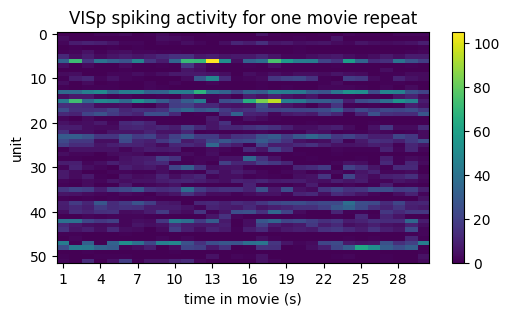

In [ ]:
# @title Plot neural activity for the first repeat of the 30s movie
plt.figure(figsize=(6, 3))
plt.imshow(neural_df[0], aspect="auto")
plt.xlabel("time in movie (s)")
plt.xticks(np.arange(0, 30, 3), np.arange(1, 31, 3))
plt.ylabel("unit")
plt.title("VISp spiking activity for one movie repeat")
plt.colorbar()
plt.show()

### [4.2.2] Activity for a given one-second bin of the movie, across all repeats

Next, let's plot the neural activity corresponding to one "stimulus bin" (i.e. a given 1-second period in the movie) across all 20 repeats.

In [ ]:
def get_session_dfs(stimulus_bin):
    """
    For a given stimulus bin (i.e. the second in the movie ranging from 0-29), return DataFrames with activity for:
        1: the first session (i.e. repeats 1-10)
        2: the second session (i.e. repeats 11-20)
        3: both sessions in one DataFrame, with a column to specify
    """
    stimulus_bin_data = pd.DataFrame() # empty DataFrame to fill
    for repeat_num in range(0, 20): # for each repeat, get the data corresponding to the stimulus bin
        stimulus_bin_data[repeat_num] = neural_df[repeat_num][stimulus_bin]

    # separate into two DataFrames (one for each session)
    session_one_df = stimulus_bin_data[[i for i in range(10)]] # first ten repeats
    session_two_df = stimulus_bin_data[[i for i in range(11, 20)]] # second ten repeats

    # modify the data to make a "combo_df" (useful for plotting with Plotly)
    combo_df = stimulus_bin_data.T # transpose to make the neurons (units) the columns instead of the rows
    combo_df["session"] = ["1" for i in range(10)] + ["2" for i in range(10)] # make a column specifying which session the data belongs to

    return session_one_df, session_two_df, combo_df

In [ ]:
# Use the function defined above to get the data organized in a useful way for plotting
stimulus_bin = 12 # we choose stimlus bin 12 (can be any integer 0 to 29)
session_one_df, session_two_df, combo_df = get_session_dfs(stimulus_bin)

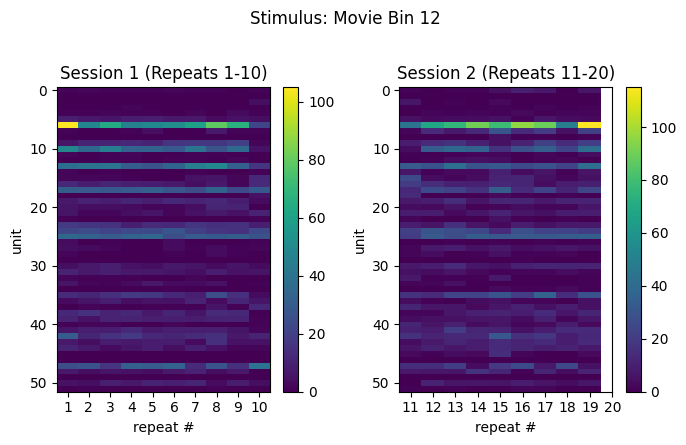

In [ ]:
# @title Plot the response for each session
fig = plt.figure(figsize=(7, 4))

# session 1
ax = fig.add_subplot(1, 2, 1)
plot1 = ax.imshow(session_one_df, aspect="auto")
ax.set_xlabel("repeat #")
ax.set_xticks(np.arange(0, 10), np.arange(1, 11)) # label x-tick marks
ax.set_ylabel("unit")
ax.set_title(f"Session 1 (Repeats 1-10)")
plt.colorbar(plot1)

# session 2
ax = fig.add_subplot(1, 2, 2)
plot1 = ax.imshow(session_two_df, aspect="auto")
ax.set_xlabel("repeat #")
ax.set_xticks(np.arange(0, 10), np.arange(11, 21)) # label x-tick marks
ax.set_ylabel("unit")
ax.set_title(f"Session 2 (Repeats 11-20)")
plt.colorbar(plot1)

plt.tight_layout()
plt.suptitle(f"Stimulus: Movie Bin {stimulus_bin}\n", y=1.1)
plt.show()

### [4.2.3] Visualizing difference in activity between sessions

* We selected three units to visualize the activity for each session, for the stimulus bin selected above.
* Use your mouse to rotate the plot below and observe the change in the neural population activity in Session 1 and Session 2.

In [ ]:
selected_units = [950934762, 950934824, 950934987]
fig = px.scatter_3d(combo_df, x=selected_units[0], y=selected_units[1], z=selected_units[2], color='session', color_discrete_sequence=color_list[:2])
fig.update_layout(width=700, height=600, font_size=11, scene_aspectmode="data", scene_camera_eye=dict (x=-1, y=2.2, z=1.6), template="none")
fig.show()

Above, we selected a set of three neurons and a stimulus bin for you. **Run the code block below to:**
- (1) Randomly select three neurons (units)
- (2) Randomly select a stimulus bin (1-second interval) within the 30-second movie

**and visualize activity from the stimulus bin from these neurons across the two sessions.**

------
**Instructions**:
- Run the code block a few times.

- Observe how some stimuli and neurons show very different activity across the two sessions, while others show more overlapping populations.

- For those blocks where the activity is very different across the two sessions, how might you quantitatively compare the two populations of activity?


In [ ]:
randomly_selected_units = random.sample(list(neural_df.index), 3)
print("Unit IDs:", randomly_selected_units)

randomly_selected_stimulus_bin = random.randint(0, 29)
print("Stimulus Bin:", randomly_selected_stimulus_bin)

_, _, combo_df = get_session_dfs(randomly_selected_stimulus_bin)
fig = px.scatter_3d(combo_df, x=randomly_selected_units[0], y=randomly_selected_units[1], z=randomly_selected_units[2], color='session', color_discrete_sequence=color_list[:2])
fig.show()

Unit IDs: [950935403, 950934750, 950936618]
Stimulus Bin: 16


## [4.3] Geometric analyses (Aitken et al., 2022)

In this section, we implement some of the geometric analyses from in [Aitken et al., 2022](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1010716), in which populations of neural activity were compared to quantify the level of "drift" in the neural representations of stimuli over time.

### [4.3.1] Defining terms

* **session**: a set of 10 repeats
    * **Session 1**: the first ten repeats (repeat # 1 through 10)
    * **Session 2**: the last ten repeats (repeat # 11 through 20)

* **stimulus bin**: a one-second period in the 30-second "natural movie" stimulus (ranging from 0 to 29)

* **mean response vector**: the mean response of each neuron for a given stimulus bin in a given session
    * for example, we can calculate a mean response vector for Stimulus Bin 5, Session 1 by calculating the mean neural activity for the corresponding 1-second bin across all 10 repeats within Session 1

* **drift vector** ($d$): the vector pointing from the mean response vector of an earlier session (Session 1) to a later session (Session 2) for a given stimulus bin
    * the drift vector is calculated by subtracting the Session 1 mean response vector from the Session 2 mean response vector, i.e. $d = v_{session 2} - v_{session 1}$
    * for example, we can calculate the drift vector between Session 1 and 2 for Stimulus Bin 5 by doing the following subtraction: (Stimulus Bin 5, Session 2 mean response vector) - (Stimulus Bin 5, Session 1 mean response vector)

* **PCs**: the principal component vectors of the neural data of a given stimulus group within a session

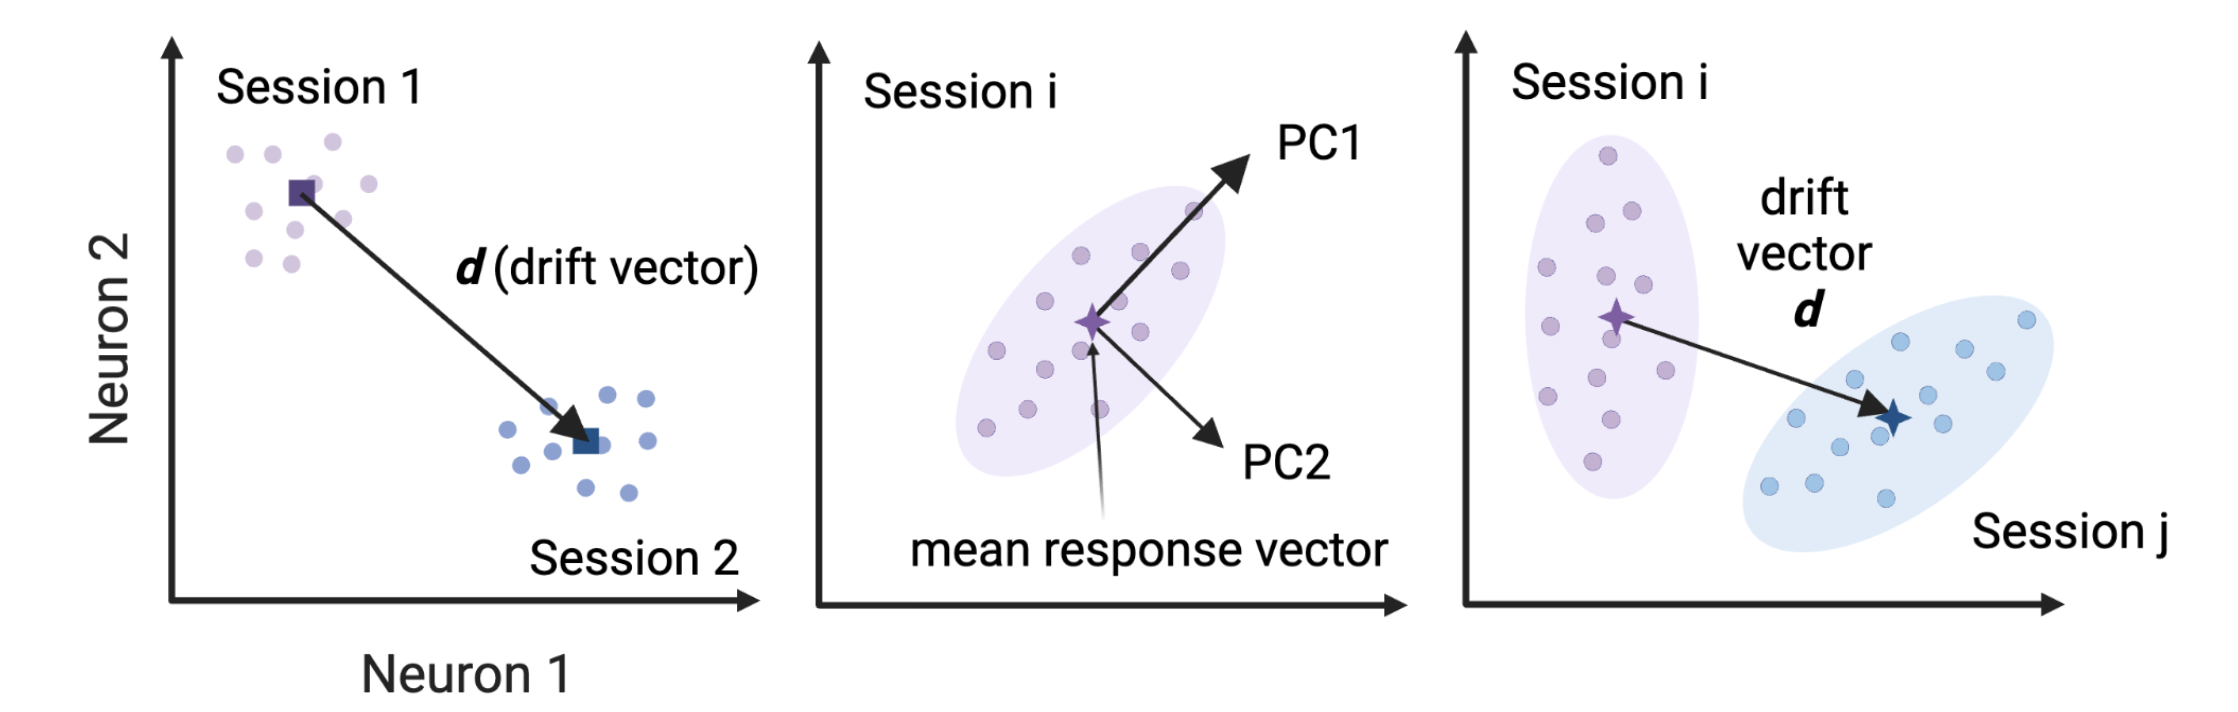

### [4.3.2] Visualizing and calculating drift vector

#### i. Example drift vector (visualization)
* Let's make the left panel of the figure above, but with our real neural data!

* Note that for the sake of visualization, we will only show two neurons below, but please note that the drift vector $d$ is calculated using the **full set of available neurons** (in our data, there are 52 neurons, so $d$ will be 52 elements long).

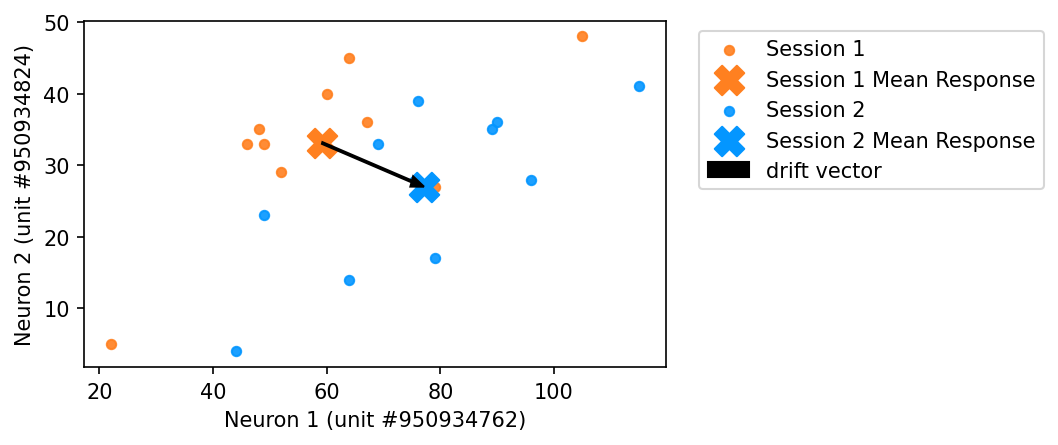

In [ ]:
# @title Plot the neural data and the drift vector
# select a stimulus bin and some units
stimulus_bin = 12
selected_units = [950934762, 950934824]

_, _, combo_df = get_session_dfs(stimulus_bin)

arrow_points = []
fig = plt.figure(figsize=(5, 3), dpi=150)
for session_num in ["1", "2"]:
    data = combo_df[combo_df["session"] == session_num]

    # plot the data from each repeat
    plt.scatter(data[selected_units[0]], data[selected_units[1]], s=20, alpha=0.9, color=color_list[int(session_num)], label=f"Session {session_num}")

    # plot the mean response vector
    plt.scatter(np.mean(data[selected_units[0]]), np.mean(data[selected_units[1]]), s=200, marker="X", color=color_list[int(session_num)], label=f"Session {session_num} Mean Response")

    # record data for plotting drift vector later
    arrow_points.append([np.mean(data[selected_units[0]]), np.mean(data[selected_units[1]])])

# plot drift vector
arrow_start, arrow_end = arrow_points
plt.arrow(arrow_start[0], arrow_start[1], arrow_end[0]-arrow_start[0], arrow_end[1]-arrow_start[1], length_includes_head=True, width=0.25, head_width=1.5, color = "k", label="drift vector")

plt.xlabel(f"Neuron 1 (unit #{selected_units[0]})")
plt.ylabel(f"Neuron 2 (unit #{selected_units[1]})")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

#### ii. Calculating drift vector for all 30 stimulus bins

The code blocks below calculate the drift vectors for all 30 stimulus bins.

In [ ]:
def get_drift_vector(stimulus_bin):
    if not (0 <= stimulus_bin <= 29):
        print("Error: Stimulus bin must be >=0 and <=29.")
        return

    # get the data
    session_one_df, session_two_df, combo_df = get_session_dfs(stimulus_bin)

    # calculate the mean response vector
    mrv_session_one = session_one_df.mean(axis=1)
    mrv_session_two = session_two_df.mean(axis=1)

    # calculate drift vector
    d = mrv_session_two - mrv_session_one

    return d

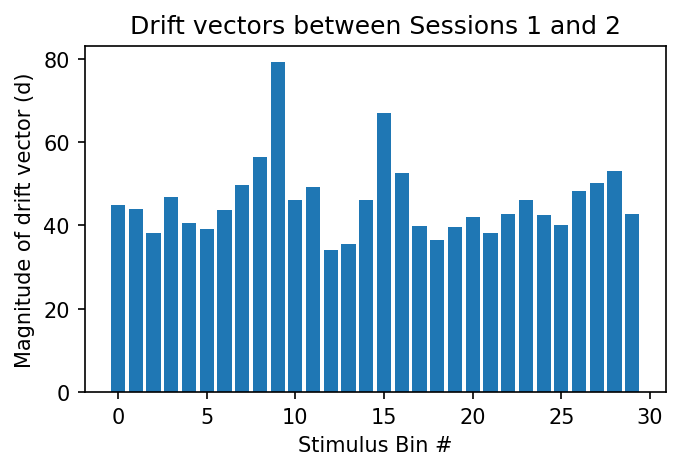

In [ ]:
plt.figure(figsize=(5, 3), dpi=150)
lengths = []
for stimulus_bin in range(30): # for each stimulus bin
    d = get_drift_vector(stimulus_bin) # calculate the drift vector
    length = np.linalg.norm(d.values) # calculate the length of the drift vector
    lengths.append(length)
plt.bar(np.arange(0, 30), lengths)
plt.xlabel("Stimulus Bin #")
plt.ylabel("Magnitude of drift vector (d)")
plt.title("Drift vectors between Sessions 1 and 2")
plt.show()

We now have the drift vectors for all 30 stimulus bins, and we have quantified the magnitude of the drift vectors. This is informative, but limited.

Let's visualize the drift vectors (in 2-D) to see if the activity for the different stimulus bins tend to drift in similar directions across the two sessions.

#### iii. Visualizing all drift vectors for all 30 stimulus bins
* Run the code block below to visualize all drift vectors **for all 30 stimulus bins** with a randomly selected set of two neurons.

* *Note that the* **mean response vector** *for each stimulus bin is being shown; the raw data points (as in the earlier drift vector plot) are not shown here.*

* Be sure to run the code block several times to see different pairs of neurons.

* What do you observe? Does the activity for the 30 different stimulus bins tend to drift in a similar direction across the two sessions?

Unit IDs: [950935440, 950935766]


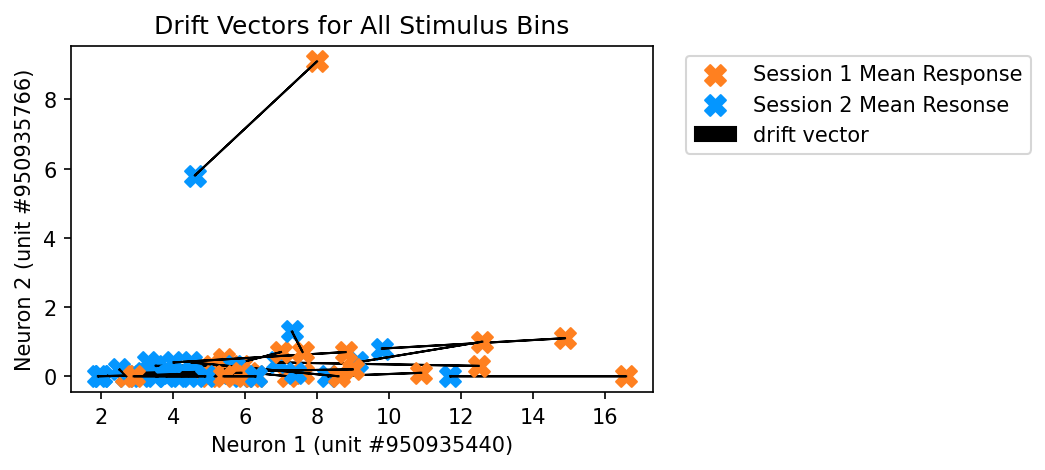

In [ ]:
# select a stimulus bin and some units
randomly_selected_units = random.sample(list(neural_df.index), 2)
print("Unit IDs:", randomly_selected_units)

fig = plt.figure(figsize=(5, 3), dpi=150)
for stimulus_bin in range(0, 30):
    # get data
    _, _, combo_df = get_session_dfs(stimulus_bin)

    arrow_points = []
    for session_num in ["1", "2"]:
        data = combo_df[combo_df["session"] == session_num]

        # plot the mean response vector
        plt.scatter(np.mean(data[randomly_selected_units[0]]), np.mean(data[randomly_selected_units[1]]), s=100, marker="X", color=color_list[int(session_num)])

        # record data for plotting drift vector later
        arrow_points.append([np.mean(data[randomly_selected_units[0]]), np.mean(data[randomly_selected_units[1]])])

    # plot drift vector
    arrow_start, arrow_end = arrow_points
    plt.arrow(arrow_start[0], arrow_start[1], arrow_end[0]-arrow_start[0], arrow_end[1]-arrow_start[1], length_includes_head=True, color = "k", label="drift vector")


plt.title("Drift Vectors for All Stimulus Bins")
plt.xlabel(f"Neuron 1 (unit #{randomly_selected_units[0]})")
plt.ylabel(f"Neuron 2 (unit #{randomly_selected_units[1]})")
plt.legend(['Session 1 Mean Response', 'Session 2 Mean Resonse', 'drift vector'], bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

### [4.3.3] Measuring alignment of drift vector with the neural activity

* We want to measure how the drift vector aligns with the variability already present in the neural representation of a stimulus.

* To investigate this question, we will first run PCA on the Session 1 neural activity for a given stimulus bin, thus capturing axes and their corresponding explained variance ratios.

* Then, we will measure the alignment of the drift vector to the Session 1 PCs. To measure the alignment of $d$ with the PCs, we will do two calculations:
    
    1. Project $d$ into the PC space and measure how much of the total magnitude of $d$ occurs along each PC, as a function of the amount of explained variance of each PC.
    
    2. Measure the angle between $d$ and each PC, as a function of the amount of variance of each PC.

In [ ]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in degrees between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * 180/np.pi

In [ ]:
def drift_analysis(stimulus_bin):

    if not (0 <= stimulus_bin <= 29):
        print("Error: Stimulus bin must be >=0 and <=29.")
        return

    # get the data
    session_one_df, session_two_df, combo_df = get_session_dfs(stimulus_bin)

    # get the drift vector and the magnitude (length) of the drift vector
    drift_vector = get_drift_vector(stimulus_bin).values
    drift_magnitude = np.linalg.norm(drift_vector)

    # run PCA on Session 1
    pca = PCA(n_components = 10)
    pca_input = session_one_df.T # input has n_samples (10 repeats) by n_features (n neurons)
    pca.fit(pca_input)

    # change the signs on some PCs to ensure the stimulus group mean is positive for all PCs
    pca_dir_signs = np.sign(np.mean(np.matmul(pca_input, pca.components_.T), axis = 0))
    for pca_idx, pca_direction in enumerate(pca.components_):
        pca.components_[pca_idx, :] = pca_dir_signs[pca_idx] * pca_direction

    # transform the stimulus group into PC space
    pca_output = pca.transform(pca_input)
    var_explained_ratio = pca.explained_variance_ratio_

    # calculate magnitude of drift along PC components
    drift_projection = np.matmul(drift_vector, pca.components_.T) # project drift vector into PC space
    magnitude_proportion_by_PC = list(abs(drift_projection)/drift_magnitude)

    # calculate angle between drift vector and each PC
    angles = []
    for component in pca.components_:
        angle = angle_between(drift_vector, component)
        angles.append(angle)

    return var_explained_ratio, magnitude_proportion_by_PC, angles


In [ ]:
def run_regression(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    y_hat = results.predict(sm.add_constant(np.arange(0, 1.1, 0.1)))
    return np.arange(0, 1.1, 0.1), y_hat, results.rsquared, results.params[1], results.pvalues[1]

#### i. Magnitude of $d$ along PCs

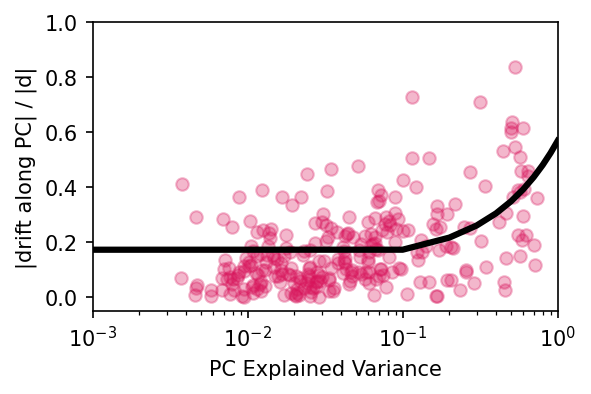

Regression results:
R^2: 0.237
beta: 0.44
p-value: <0.001


In [ ]:
#@title Plot magnitude of d along PCs
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=150)

regression_data = {"x": [], "y": []}

for stimulus_bin in range(30):
    # run the drift analysis (comparing drift vector to Session 1 PCA)
    PC_variance_explained, drift_magnitude_along_PC, drift_angle_with_PC = drift_analysis(stimulus_bin)

    # plot variance explained by a PC vs. the magnitude of the drift vector along that PC
    ax.scatter(PC_variance_explained, drift_magnitude_along_PC, color = color_list[0], alpha = 0.3)

    # record the data in a dictionary so we can run a regression later
    regression_data["x"] += (list(PC_variance_explained))
    regression_data["y"] += (list(drift_magnitude_along_PC))

x, y_hat, rsquared, beta, p = run_regression(regression_data["x"], regression_data["y"])
plt.plot(x, y_hat, color="k", linewidth=3)

ax.set_xscale("log") # set x-axis to a log scale
plt.xlim(10**(-3), 1)
plt.ylim(-0.05, 1)

plt.xlabel("PC Explained Variance")
plt.ylabel("|drift along PC| / |d|")
plt.show()

print("Regression results:")
print(f"R^2: {np.round(rsquared, 3)}")
print(f"beta: {np.round(beta, 3)}")
if p < 0.001:
    print("p-value: <0.001")
else:
    print(f"p-value: {np.round(p, 3)}")

#### ii. Angle of $d$ with PCs

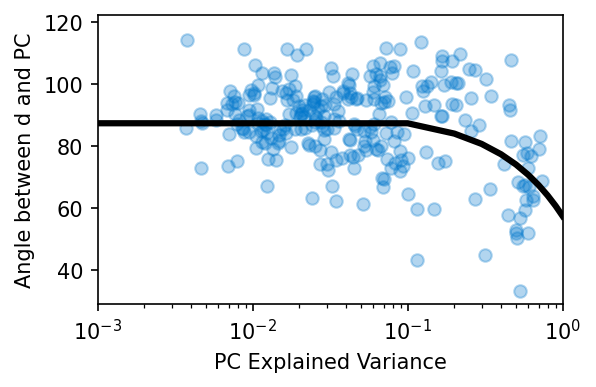

Regression results:
R^2: 0.166
beta: -33.305
p-value: <0.001


In [ ]:
# @title Plot angle of d with PCs
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=150)

regression_data = {"x": [], "y": []}

for stimulus_bin in range(30):
    # run the drift analysis (comparing drift vector to Session 1 PCA)
    PC_variance_explained, drift_magnitude_along_PC, drift_angle_with_PC = drift_analysis(stimulus_bin)

    # plot variance explained by a PC vs. the magnitude of the drift vector along that PC
    ax.scatter(PC_variance_explained, drift_angle_with_PC, color = color_list[3], alpha = 0.3)

    # record the data in a dictionary so we can run a regression later
    regression_data["x"] += (list(PC_variance_explained))
    regression_data["y"] += (list(drift_angle_with_PC))

x, y_hat, rsquared, beta, p = run_regression(regression_data["x"], regression_data["y"])
plt.plot(x, y_hat, color="k", linewidth=3)

ax.set_xscale("log") # set x-axis to a log scale
plt.xlim(10**(-3), 1)


plt.xlabel("PC Explained Variance")
plt.ylabel("Angle between d and PC")
plt.show()

print("Regression results:")
print(f"R^2: {np.round(rsquared, 3)}")
print(f"beta: {np.round(beta, 3)}")
if p < 0.001:
    print("p-value: <0.001")
else:
    print(f"p-value: {np.round(p, 3)}")